In [ ]:
!pip install pydot
!pip install pydot_ng
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!sudo pip install plot_model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!git clone https://github.com/Qinbf/plot_model.git

Cloning into 'plot_model'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 74 (delta 32), reused 57 (delta 18), pack-reused 0
Unpacking objects: 100% (74/74), done.


In [ ]:
!cd plot_model
!sudo python setup.py install

python3: can't open file 'setup.py': [Errno 2] No such file or directory


### Data

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config) 

In [ ]:

from sklearn.model_selection import train_test_split
import numpy as np


path = '/content/drive/MyDrive/Final project/'
images = np.load(path + 'images_256.npy')
masks = np.load(path + 'masks_256.npy')

images = images[..., np.newaxis]
masks = masks[..., np.newaxis]

for i in range(images.shape[0]):
  images[i,:, :] = (images[i,:, :] - np.mean(images[i,:, :]))/ np.std(images[i,:, :])


images_train, images_test, masks_train, masks_test = train_test_split(images, masks, test_size=0.2, random_state=1)


print ("Images_train shape: " + str(images_train.shape))
print ("Masks_train shape: " + str(masks_train.shape))

print ("Images_test shape: " + str(images_test.shape))
print ("Masks_test shape: " + str(masks_test.shape))

Images_train shape: (2451, 256, 256, 1)
Masks_train shape: (2451, 256, 256, 1)
Images_test shape: (613, 256, 256, 1)
Masks_test shape: (613, 256, 256, 1)


### SwinUnet

In [ ]:

from __future__ import absolute_import

import warnings
import numpy as np
import tensorflow as tf
from tensorflow import math
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input
from tensorflow.nn import depth_to_space
from tensorflow.image import extract_patches
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.activations import softmax
from tensorflow.keras.layers import Layer, MultiHeadAttention, LayerNormalization, Dense, Embedding, Dropout, Conv2D, BatchNormalization, Activation, concatenate, multiply, add
from tensorflow.keras.layers import UpSampling2D, Conv2DTranspose, MaxPooling2D, AveragePooling2D, Flatten, Reshape
from tensorflow.keras.layers import ReLU, LeakyReLU, PReLU, ELU, Softmax
from plot_model import plot_model


def CONV_output(X, n_labels, kernel_size=1, activation='Softmax', name='conv_output'):
    '''
    Convolutional layer with output activation.
    '''
    
    X = Conv2D(n_labels, kernel_size, padding='same', use_bias=True, name=name)(X)
    
    if activation:
        
        if activation == 'Sigmoid':
            X = Activation('sigmoid', name='{}_activation'.format(name))(X)
            
        else:
            activation_func = eval(activation)
            X = activation_func(name='{}_activation'.format(name))(X)
            
    return X

class patch_extract(Layer):
    '''
    Extract patches from the input feature map.
    patches = patch_extract(patch_size)(feature_map)
    '''
    
    def __init__(self, patch_size, **kwargs):
        super(patch_extract, self).__init__(**kwargs)
        self.patch_size = patch_size
        self.patch_size_x = patch_size[0]
        self.patch_size_y = patch_size[0]
    
    def call(self, images):
        
        batch_size = tf.shape(images)[0]
        
        patches = extract_patches(images=images,
                                  sizes=(1, self.patch_size_x, self.patch_size_y, 1),
                                  strides=(1, self.patch_size_x, self.patch_size_y, 1),
                                  rates=(1, 1, 1, 1), padding='VALID',)
        # patches.shape = (num_sample, patch_num, patch_num, patch_size*channel)
        
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        patches = tf.reshape(patches, (batch_size, patch_num*patch_num, patch_dim))
        # patches.shape = (num_sample, patch_num*patch_num, patch_size*channel)
        
        return patches
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({'patch_size': self.patch_size,})
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
class patch_embedding(Layer):
    '''
    Embed patches to tokens.
    patches_embed = patch_embedding(num_patch, embed_dim)(pathes)
    '''
    
    def __init__(self, num_patch, embed_dim, **kwargs):
        
        super(patch_embedding, self).__init__(**kwargs)
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.proj = Dense(embed_dim)
        self.pos_embed = Embedding(input_dim=num_patch, output_dim=embed_dim)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_patch': self.num_patch,
            'embed_dim': self.embed_dim,
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        embed = self.proj(patch) + self.pos_embed(pos)
        return embed



class patch_merging(tf.keras.layers.Layer):
    '''
    Downsample embedded patches; it halfs the number of patches
    and double the embedded dimensions (c.f. pooling layers).
    
    '''
    def __init__(self, num_patch, embed_dim, name='', **kwargs):
        super(patch_merging, self).__init__(**kwargs)
        
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        
        # A linear transform that doubles the channels 
        self.linear_trans = Dense(2*embed_dim, use_bias=False, name='{}_linear_trans'.format(name))

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_patch': self.num_patch,
            'embed_dim': self.embed_dim,
            'name':self.name
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
    def call(self, x):
        
        H, W = self.num_patch
        B, L, C = x.get_shape().as_list()
        
        assert (L == H * W), 'input feature has wrong size'
        assert (H % 2 == 0 and W % 2 == 0), '{}-by-{} patches received, they are not even.'.format(H, W)
        
        # Convert the patch sequence to aligned patches
        x = tf.reshape(x, shape=(-1, H, W, C))
        
        # Downsample
        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        
        # Convert to the patch squence
        x = tf.reshape(x, shape=(-1, (H//2)*(W//2), 4*C))
       
        # Linear transform
        x = self.linear_trans(x)

        return x

class patch_expanding(tf.keras.layers.Layer):
    '''
    Upsample embedded patches with a given rate (e.g., x2, x4, x8, ...) 
    the number of patches is increased, and the embedded dimensions are reduced.
    '''

    def __init__(self, num_patch, embed_dim, upsample_rate, return_vector=True, name='patch_expand', **kwargs):
        super(patch_expanding, self).__init__(**kwargs)
        
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.upsample_rate = upsample_rate
        self.return_vector = return_vector
        
        # Linear transformations that doubles the channels 
        self.linear_trans1 = Conv2D(upsample_rate*embed_dim, kernel_size=1, use_bias=False, name='{}_linear_trans1'.format(name))
        # 
        self.linear_trans2 = Conv2D(upsample_rate*embed_dim, kernel_size=1, use_bias=False, name='{}_linear_trans1'.format(name))
        self.prefix = name
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_patch': self.num_patch,
            'embed_dim': self.embed_dim,
            'upsample_rate': self.upsample_rate,
            'return_vector': self.return_vector,
            'name':self.name,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
    def call(self, x):
        
        H, W = self.num_patch
        B, L, C = x.get_shape().as_list()
        
        assert (L == H * W), 'input feature has wrong size'

        x = tf.reshape(x, (-1, H, W, C))
        
        x = self.linear_trans1(x)
        
        # rearange depth to number of patches
        x = depth_to_space(x, self.upsample_rate, data_format='NHWC', name='{}_d_to_space'.format(self.prefix))
        
        if self.return_vector:
            # Convert aligned patches to a patch sequence
            x = tf.reshape(x, (-1, L*self.upsample_rate*self.upsample_rate, C//2))

        return x
    


def window_partition(x, window_size):
    
    # Get the static shape of the input tensor
    # (Sample, Height, Width, Channel)
    _, H, W, C = x.get_shape().as_list()
    
    # Subset tensors to patches
    patch_num_H = H//window_size
    patch_num_W = W//window_size
    x = tf.reshape(x, shape=(-1, patch_num_H, window_size, patch_num_W, window_size, C))
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    
    # Reshape patches to a patch sequence
    windows = tf.reshape(x, shape=(-1, window_size, window_size, C))
    
    return windows

def window_reverse(windows, window_size, H, W, C):
    
    # Reshape a patch sequence to aligned patched 
    patch_num_H = H//window_size
    patch_num_W = W//window_size
    x = tf.reshape(windows, shape=(-1, patch_num_H, patch_num_W, window_size, window_size, C))
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    
    # Merge patches to spatial frames
    x = tf.reshape(x, shape=(-1, H, W, C))
    
    return x

def drop_path_(inputs, drop_prob, is_training):
    
    # Bypass in non-training mode
    if (not is_training) or (drop_prob == 0.):
        return inputs

    # Compute keep_prob
    keep_prob = 1.0 - drop_prob

    # Compute drop_connect tensor
    input_shape = tf.shape(inputs)
    batch_num = input_shape[0]; rank = len(input_shape)
    
    shape = (batch_num,) + (1,) * (rank - 1)
    random_tensor = keep_prob + tf.random.uniform(shape, dtype=inputs.dtype)
    path_mask = tf.floor(random_tensor)
    output = tf.math.divide(inputs, keep_prob) * path_mask
    return output

class drop_path(Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super(drop_path, self).__init__(**kwargs)
        self.drop_prob = drop_prob

    def get_config(self):
        config = super().get_config().copy()
        config.update({'drop_prob': self.drop_prob})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
    def call(self, x, training=None):
        return drop_path_(x, self.drop_prob, training)
 
class Mlp(tf.keras.layers.Layer):
    def __init__(self, filter_num, drop=0., name='mlp', **kwargs):
        
        super(Mlp, self).__init__(**kwargs)
        
        self.filter_num = filter_num
        self.drop = drop
        
        # MLP layers
        self.fc1 = Dense(filter_num[0], name='{}_mlp_0'.format(name))
        self.fc2 = Dense(filter_num[1], name='{}_mlp_1'.format(name))
        
        # Dropout layer
        self.drop = Dropout(drop)
        
        # GELU activation
        self.activation = tf.keras.activations.gelu
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'filter_num': self.filter_num,
            'drop': self.drop,
            'name': self.name,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
    def call(self, x):
        
        # MLP --> GELU --> Drop --> MLP --> Drop
        x = self.fc1(x)
        x = self.activation(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        
        return x

class WindowAttention(tf.keras.layers.Layer):
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, 
                 attn_drop=0, proj_drop=0., name='swin_atten', **kwargs):
        super(WindowAttention, self).__init__(**kwargs)
        
        self.dim = dim # number of input dimensions
        self.window_size = window_size # size of the attention window
        self.num_heads = num_heads # number of self-attention heads
        self.qkv_bias = qkv_bias
        self.qk_scale = qk_scale
        self.attn_drop = attn_drop
        self.proj_drop = proj_drop
        
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5 # query scaling factor
        
        self.prefix = name
        
        # Layers
        self.qkv = Dense(dim * 3, use_bias=qkv_bias, name='{}_attn_qkv'.format(self.prefix))
        self.attn_drop = Dropout(attn_drop)
        self.proj = Dense(dim, name='{}_attn_proj'.format(self.prefix))
        self.proj_drop = Dropout(proj_drop)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'dim':self.dim, 
            'window_size':self.window_size, 
            'num_heads':self.num_heads, 
            'qkv_bias':self.qkv_bias, 
            'qk_scale':self.qk_scale, 
            'attn_drop':self.attn_drop, 
            'proj_drop':self.proj_drop, 
            'name':self.prefix
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
        
    def build(self, input_shape):
        
        # zero initialization
        num_window_elements = (2*self.window_size[0] - 1) * (2*self.window_size[1] - 1)
        self.relative_position_bias_table = self.add_weight('{}_attn_pos'.format(self.prefix),
                                                            shape=(num_window_elements, self.num_heads),
                                                            initializer=tf.initializers.Zeros(), trainable=True)
        
        # Indices of relative positions
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing='ij')
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)
        
        # convert to the tf variable
        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False, name='{}_attn_pos_ind'.format(self.prefix))
        
        self.built = True

    def call(self, x, mask=None):
        
        # Get input tensor static shape
        _, N, C = x.get_shape().as_list()
        head_dim = C//self.num_heads
        
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, N, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        
        # Query rescaling
        q = q * self.scale
        
        # multi-headed self-attention
        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = (q @ k)
        
        # Shift window
        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(self.relative_position_index, shape=(-1,))
        relative_position_bias = tf.gather(self.relative_position_bias_table, relative_position_index_flat)
        relative_position_bias = tf.reshape(relative_position_bias, shape=(num_window_elements, num_window_elements, -1))
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32)
            attn = tf.reshape(attn, shape=(-1, nW, self.num_heads, N, N)) + mask_float
            attn = tf.reshape(attn, shape=(-1, self.num_heads, N, N))
            attn = softmax(attn, axis=-1)
        else:
            attn = softmax(attn, axis=-1)
        
        # Dropout after attention
        attn = self.attn_drop(attn)
        
        # Merge qkv vectors
        x_qkv = (attn @ v)
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))
        x_qkv = tf.reshape(x_qkv, shape=(-1, N, C))
        
        # Linear projection
        x_qkv = self.proj(x_qkv)
        
        # Dropout after projection
        x_qkv = self.proj_drop(x_qkv)
        
        return x_qkv

class SwinTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, dim, num_patch, num_heads, window_size=7, shift_size=0, 
                 num_mlp=1024, qkv_bias=True, qk_scale=None, mlp_drop=0, attn_drop=0, 
                 proj_drop=0, drop_path_prob=0, name='swin_block', **kwargs):
        
        super(SwinTransformerBlock, self).__init__(**kwargs)
        
        self.dim = dim # number of input dimensions
        self.num_patch = num_patch # number of embedded patches; a tuple of  (heigh, width)
        self.num_heads = num_heads # number of attention heads
        self.window_size = window_size # size of window
        self.shift_size = shift_size # size of window shift
        self.num_mlp = num_mlp # number of MLP nodes
        self.qkv_bias = qkv_bias
        self.qk_scale = qk_scale
        self.mlp_drop = mlp_drop
        self.attn_drop = attn_drop
        self.proj_drop = proj_drop
        self.drop_path_prob = drop_path_prob
        
        self.prefix = name
        
        # Layers
        self.norm1 = LayerNormalization(epsilon=1e-5, name='{}_norm1'.format(self.prefix))
        self.attn = WindowAttention(dim, window_size=(self.window_size, self.window_size), num_heads=num_heads,
                                    qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=proj_drop, name=self.prefix)
        self.drop_path = drop_path(drop_path_prob)
        self.norm2 = LayerNormalization(epsilon=1e-5, name='{}_norm2'.format(self.prefix))
        self.mlp = Mlp([num_mlp, dim], drop=mlp_drop, name=self.prefix)
        
        # Assertions
        assert 0 <= self.shift_size, 'shift_size >= 0 is required'
        assert self.shift_size < self.window_size, 'shift_size < window_size is required'
        
        # <---!!!
        # Handling too-small patch numbers
        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'dim':self.dim, 
            'num_patch':self.num_patch, 
            'num_heads':self.num_heads, 
            'window_size':self.window_size, 
            'shift_size':self.shift_size, 
            'num_mlp':self.num_mlp,
            'qkv_bias':self.qkv_bias, 
            'qk_scale':self.qk_scale, 
            'mlp_drop':self.mlp_drop, 
            'attn_drop':self.attn_drop, 
            'proj_drop':self.proj_drop, 
            'drop_path_prob':self.drop_path_prob, 
            'name':self.prefix
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
    def build(self, input_shape):
        if self.shift_size > 0:
            H, W = self.num_patch
            h_slices = (slice(0, -self.window_size), slice(-self.window_size, -self.shift_size), slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size), slice(-self.window_size, -self.shift_size), slice(-self.shift_size, None))
            
            # attention mask
            mask_array = np.zeros((1, H, W, 1))
            
            ## initialization
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)
            
            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(mask_windows, shape=[-1, self.window_size * self.window_size])
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(mask_windows, axis=2)
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False, name='{}_attn_mask'.format(self.prefix))
        else:
            self.attn_mask = None

        self.built = True

    def call(self, x):
        H, W = self.num_patch
        B, L, C = x.get_shape().as_list()
        
        # Checking num_path and tensor sizes
        assert L == H * W, 'Number of patches before and after Swin-MSA are mismatched.'
        
        # Skip connection I (start)
        x_skip = x
        
        # Layer normalization
        x = self.norm1(x)
        
        # Convert to aligned patches
        x = tf.reshape(x, shape=(-1, H, W, C))

        # Cyclic shift
        if self.shift_size > 0:
            shifted_x = tf.roll(x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2])
        else:
            shifted_x = x

        # Window partition 
        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(x_windows, shape=(-1, self.window_size * self.window_size, C))

        # Window-based multi-headed self-attention
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        # Merge windows
        attn_windows = tf.reshape(attn_windows, shape=(-1, self.window_size, self.window_size, C))
        shifted_x = window_reverse(attn_windows, self.window_size, H, W, C)

        # Reverse cyclic shift
        if self.shift_size > 0:
            x = tf.roll(shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2])
        else:
            x = shifted_x
            
        # Convert back to the patch sequence
        x = tf.reshape(x, shape=(-1, H*W, C))

        # Drop-path
        ## if drop_path_prob = 0, it will not drop
        x = self.drop_path(x)
        
        # Skip connection I (end)
        x = x_skip +  x
        
        # Skip connection II (start)
        x_skip = x
        
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        
        # Skip connection II (end)
        x = x_skip + x

        return x


def swin_transformer_stack(X, stack_num, embed_dim, num_patch, num_heads, window_size, num_mlp, shift_window=True, name=''):
    '''
    Stacked Swin Transformers that share the same token size.
    
    Alternated Window-MSA and Swin-MSA will be configured if `shift_window=True`, Window-MSA only otherwise.
    *Dropout is turned off.
    '''
    # Turn-off dropouts
    mlp_drop_rate = 0 # Droupout after each MLP layer
    attn_drop_rate = 0 # Dropout after Swin-Attention
    proj_drop_rate = 0 # Dropout at the end of each Swin-Attention block, i.e., after linear projections
    drop_path_rate = 0 # Drop-path within skip-connections
    
    qkv_bias = True # Convert embedded patches to query, key, and values with a learnable additive value
    qk_scale = None # None: Re-scale query based on embed dimensions per attention head # Float for user specified scaling factor
    
    if shift_window:
        shift_size = window_size // 2
    else:
        shift_size = 0
    
    for i in range(stack_num):
    
        if i % 2 == 0:
            shift_size_temp = 0
        else:
            shift_size_temp = shift_size

        X = SwinTransformerBlock(dim=embed_dim, num_patch=num_patch, num_heads=num_heads, 
                                 window_size=window_size, shift_size=shift_size_temp, num_mlp=num_mlp, qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 mlp_drop=mlp_drop_rate, attn_drop=attn_drop_rate, proj_drop=proj_drop_rate, drop_path_prob=drop_path_rate, 
                                 name='name{}'.format(i))(X)
    return X


def swin_unet_2d_base(input_tensor, filter_num_begin, depth, stack_num_down, stack_num_up, 
                      patch_size, num_heads, window_size, num_mlp, shift_window=True, name='swin_unet'):
    
    # Compute number be patches to be embeded
    input_size = input_tensor.shape.as_list()[1:]
    num_patch_x = input_size[0]//patch_size[0]
    num_patch_y = input_size[1]//patch_size[1]
    
    # Number of Embedded dimensions
    embed_dim = filter_num_begin
    
    depth_ = depth
    
    X_skip = []

    X = input_tensor
    
    # Patch extraction
    X = patch_extract(patch_size)(X)

    # Embed patches to tokens
    X = patch_embedding(num_patch_x*num_patch_y, embed_dim)(X)
    
    # The first Swin Transformer stack
    X = swin_transformer_stack(X, stack_num=stack_num_down, 
                               embed_dim=embed_dim, num_patch=(num_patch_x, num_patch_y), 
                               num_heads=num_heads[0], window_size=window_size[0], num_mlp=num_mlp, 
                               shift_window=shift_window, name='{}_swin_down0'.format(name))
    X_skip.append(X)
    
    # Downsampling blocks
    for i in range(depth_-1):
        
        # Patch merging
        X = patch_merging((num_patch_x, num_patch_y), embed_dim=embed_dim, name='down{}'.format(i))(X)
        
        # update token shape info
        embed_dim = embed_dim*2
        num_patch_x = num_patch_x//2
        num_patch_y = num_patch_y//2
        
        # Swin Transformer stacks
        X = swin_transformer_stack(X, stack_num=stack_num_down, 
                                   embed_dim=embed_dim, num_patch=(num_patch_x, num_patch_y), 
                                   num_heads=num_heads[i+1], window_size=window_size[i+1], num_mlp=num_mlp, 
                                   shift_window=shift_window, name='{}_swin_down{}'.format(name, i+1))
        
        # Store tensors for concat
        X_skip.append(X)
        
    # reverse indexing encoded tensors and hyperparams
    X_skip = X_skip[::-1]
    num_heads = num_heads[::-1]
    window_size = window_size[::-1]
    
    # upsampling begins at the deepest available tensor
    X = X_skip[0]
    
    # other tensors are preserved for concatenation
    X_decode = X_skip[1:]
    
    depth_decode = len(X_decode)
    
    for i in range(depth_decode):
        
        # Patch expanding
        X = patch_expanding(num_patch=(num_patch_x, num_patch_y),
                            embed_dim=embed_dim, upsample_rate=2, return_vector=True, name='{}_swin_up{}'.format(name, i))(X)
        

        # update token shape info
        embed_dim = embed_dim//2
        num_patch_x = num_patch_x*2
        num_patch_y = num_patch_y*2
        
        # Concatenation and linear projection
        X = concatenate([X, X_decode[i]], axis=-1, name='{}_concat_{}'.format(name, i))
        X = Dense(embed_dim, use_bias=False, name='{}_concat_linear_proj_{}'.format(name, i))(X)
        
        # Swin Transformer stacks
        X = swin_transformer_stack(X, stack_num=stack_num_up, 
                           embed_dim=embed_dim, num_patch=(num_patch_x, num_patch_y), 
                           num_heads=num_heads[i], window_size=window_size[i], num_mlp=num_mlp, 
                           shift_window=shift_window, name='{}_swin_up{}'.format(name, i))
        
    # The last expanding layer; it produces full-size feature maps based on the patch size
    # !!! <--- "patch_size[0]" is used; it assumes patch_size = (size, size)
    X = patch_expanding(num_patch=(num_patch_x, num_patch_y),
                        embed_dim=embed_dim, upsample_rate=patch_size[0], return_vector=False)(X)
    
    return X


def swin_unet_2d(input_size, filter_num_begin, n_labels, depth, stack_num_down, stack_num_up, 
                      patch_size, num_heads, window_size, num_mlp, output_activation='Softmax', shift_window=True, name='swin_unet'):
    
    IN = Input(input_size)
    
    # base    
    X = swin_unet_2d_base(IN, filter_num_begin=filter_num_begin, depth=depth, stack_num_down=stack_num_down, stack_num_up=stack_num_up, 
                          patch_size=patch_size, num_heads=num_heads, window_size=window_size, num_mlp=num_mlp, shift_window=True, name=name)
    
    # output layer
    OUT = CONV_output(X, n_labels, kernel_size=1, activation=output_activation, name='{}_output'.format(name))
    
    # functional API model
    model = Model(inputs=[IN,], outputs=[OUT,], name='{}_model'.format(name))
    
    return model


swin = swin_unet_2d((256, 256, 1), filter_num_begin=64, n_labels=1, depth=4, stack_num_down=2, stack_num_up=2, 
                            patch_size=(2, 2), num_heads=[4, 8, 8, 8], window_size=[4, 2, 2, 2], num_mlp=512, 
                            output_activation='Sigmoid', shift_window=True, name='swin_unet')

swin.load_weights("/content/drive/MyDrive/Final project/SwinUnet.h5")
# swin.summary()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### UneXt

In [ ]:

def convblock(x, filters, kernel = 3):

    l = Conv2D(filters, kernel, padding='same')(x)
    l = BatchNormalization()(l)
    l = Activation('relu')(l)
    return l


def shiftmlp(x, features, H, W, kernel = 1, drop = 0):

    l = tf.transpose(x, (0, 2, 1, 3))
    l = tf.roll(l, 2, axis=0)
    l = tf.transpose(l, (0, 2, 1, 3))

    l = Conv2D(features, 3, strides=2, padding='same')(l)
    l = Flatten()(l)
    l = Dense(H*W, activation='linear')(l)
    l = Reshape((H, W, 1))(l)

    l = Conv2D(features, kernel, padding='same')(l)
    l = Activation('gelu')(l)
    l = Dropout(drop)(l)

    return l


def shiftedBlock(x, features, H, W, kernel = 1, drop = 0):

    l = LayerNormalization()(x)
    l = shiftmlp(l, features, H, W, kernel, drop)
    l = Activation('gelu')(l)
    return l


def tokMLPBlock(x, features, H, W, kernel = 1, drop = 0):
  
    l1 = shiftedBlock(x, features, H, W, kernel, drop)
    l = Activation('gelu')(l1)
    l = shiftedBlock(l, features, H, W, kernel, drop)
    l = LayerNormalization()(l)
    l2 = Conv2D(features, 3, padding='same')(l)
    l = concatenate([l1, l2])
    return l


inputs = Input(shape = (256, 256 , 1))
# conv stage 1
x = convblock(inputs, 64)
x = MaxPooling2D()(x)
t1 = x
# conv stage 2
x = convblock(x, 128)
x = MaxPooling2D()(x)
t2 = x
# conv state 3
x = convblock(x, 256)
x = MaxPooling2D()(x)
t3 = x
# tok mlp stage 4
x = tokMLPBlock(x, 64, 16, 16, drop=0.25)
t4 = x
# bottleneck
x = tokMLPBlock(x, 128, 8, 8, drop=0.25)
t5 = x
# tok mlp stage 4
x = tokMLPBlock(x, 64, 16, 16, drop=0.25)
x = concatenate([x, t4])

x = Conv2DTranspose(256, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = concatenate([x, t3])
# conv stage 3
x = Conv2DTranspose(128, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = concatenate([x, t2])
# conv stage 2
x = Conv2DTranspose(64, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = concatenate([x, t1])
# conv stage 1
x = Conv2DTranspose(32, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(1, 1, padding='same')(x)
out = Activation('sigmoid')(x)


unext = Model(inputs, out)
unext.load_weights("/content/drive/MyDrive/Final project/CustomUNeXt.h5")
# unext.summary()

### Combined Model

In [ ]:
swin_without_top_layer = Model(swin.inputs, swin.layers[-3].output)
unext_without_top_layer = Model(unext.inputs, unext.layers[-3].output)

for layer in unext_without_top_layer.layers:
    layer.trainable = False

for layer in swin_without_top_layer.layers:
    layer.trainable = False

print(f"Swin Output: {swin_without_top_layer.output_shape}")
print(f"UneXt Output: {unext_without_top_layer.output_shape}")

Swin Output: (None, 256, 256, 32)
UneXt Output: (None, 256, 256, 32)


Model: "Combined_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 256, 256, 32  9366504     ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 model_2 (Functional)           (None, 256, 256, 32  9836768     ['input_4[0][0]']                
                                )                                                    

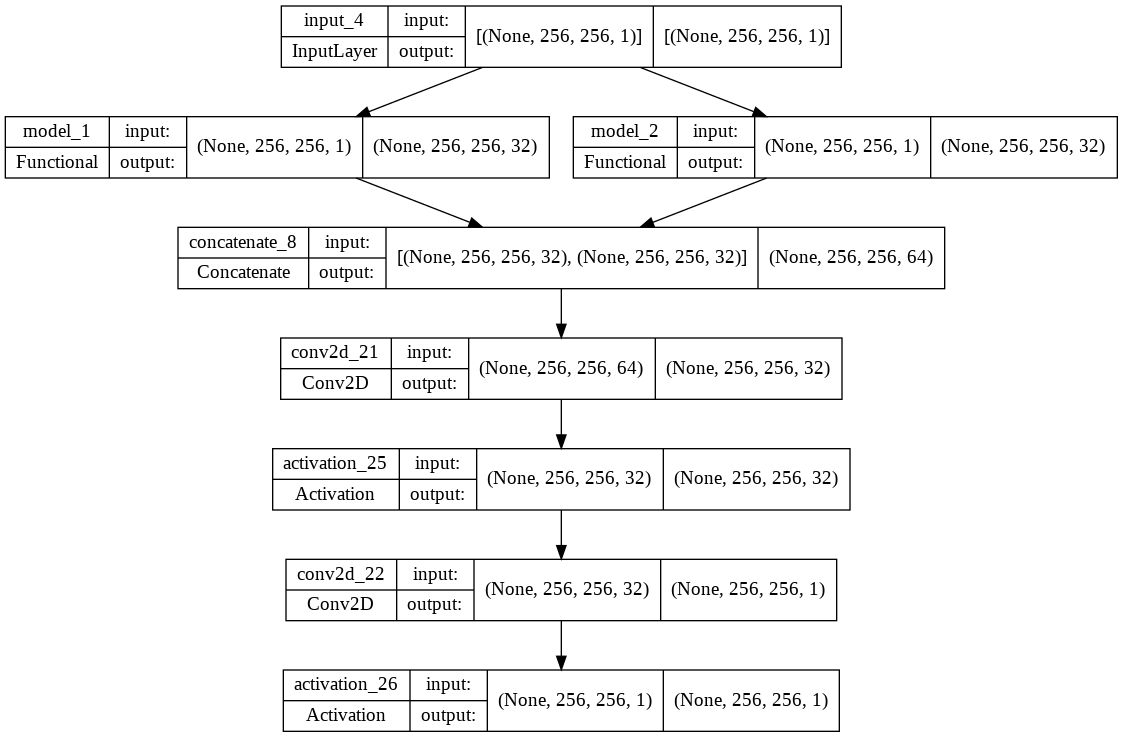

In [ ]:
inp = Input(shape = (256, 256 , 1))

Swin_Model = swin_without_top_layer(inp)
Unext_Model = unext_without_top_layer(inp)
x = concatenate([Swin_Model, Unext_Model])
x = Conv2D(32, 3, padding='same')(x)
x = Activation('relu')(x)
x = Conv2D(1, 1, padding='same')(x)
out = Activation('sigmoid')(x)

combined = Model(inp, out, name="Combined_Model")
combined.summary()
tf.keras.utils.plot_model(combined, show_shapes=True)

In [ ]:
from tensorflow.keras.losses import binary_crossentropy

smooth = 1
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [ ]:
combined.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
              loss = 'binary_crossentropy', 
              metrics=[dice_coef]) 

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler

# model checkpoint callback
model_weights_saving_path = "/content/drive/MyDrive/Final project/CombinedModel.h5"
checkpoint = ModelCheckpoint(model_weights_saving_path, verbose=1, save_best_only=True, save_weights_only=True, monitor = 'dice_coef', mode='max')


# early stopping after 7 epochs
stop = EarlyStopping(patience=7, monitor='dice_coef', mode='max', verbose=1)

history = combined.fit(images_train, masks_train, 
                    epochs = 10, 
                    batch_size = 2,
                    callbacks = [checkpoint, stop], 
                    validation_data = (images_test, masks_test)) 

Epoch 1/10
1226/1226 [==============================] - ETA: 0s - loss: 0.0161 - dice_coef: 0.8756
Epoch 1: dice_coef improved from -inf to 0.87557, saving model to /content/drive/MyDrive/Final project/CombinedModel.h5
1226/1226 [==============================] - 145s 106ms/step - loss: 0.0161 - dice_coef: 0.8756 - val_loss: 0.0622 - val_dice_coef: 0.5583
Epoch 2/10
1226/1226 [==============================] - ETA: 0s - loss: 0.0057 - dice_coef: 0.8840
Epoch 2: dice_coef improved from 0.87557 to 0.88395, saving model to /content/drive/MyDrive/Final project/CombinedModel.h5
1226/1226 [==============================] - 124s 102ms/step - loss: 0.0057 - dice_coef: 0.8840 - val_loss: 0.0584 - val_dice_coef: 0.5587
Epoch 3/10
1226/1226 [==============================] - ETA: 0s - loss: 0.0056 - dice_coef: 0.8850
Epoch 3: dice_coef improved from 0.88395 to 0.88504, saving model to /content/drive/MyDrive/Final project/CombinedModel.h5
1226/1226 [==============================] - 124s 101ms/ste

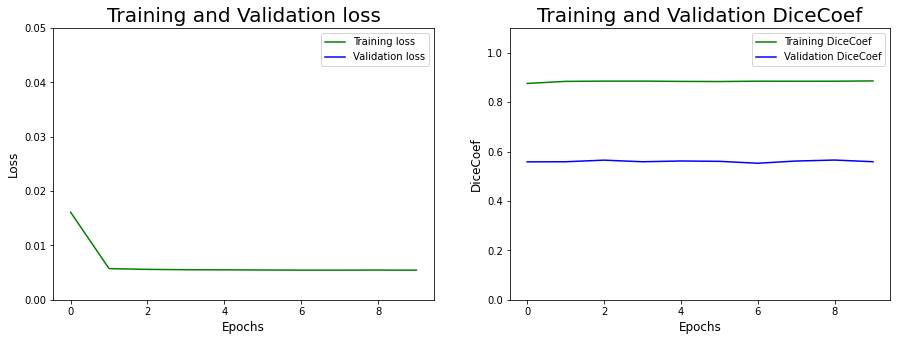

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

epochs = list(range(10))


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], 'g', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.xlabel('Epochs', size=12)
plt.ylabel('Loss', size=12)
plt.ylim(0, 0.05)

plt.title('Training and Validation loss', size=20)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['dice_coef'], 'g', label='Training DiceCoef')
plt.plot(epochs, history.history['val_dice_coef'], 'b', label='Validation DiceCoef')
plt.xlabel('Epochs', size=12)
plt.ylabel('DiceCoef', size=12)
plt.ylim(0, 1.1)

plt.title('Training and Validation DiceCoef', size=20)
plt.legend()

plt.show()

In [ ]:
combined.load_weights("/content/drive/MyDrive/Final project/CombinedModel.h5")
predictions = combined.predict(images_train[0:1,:,:,:])

In [ ]:
import matplotlib.pyplot as plt

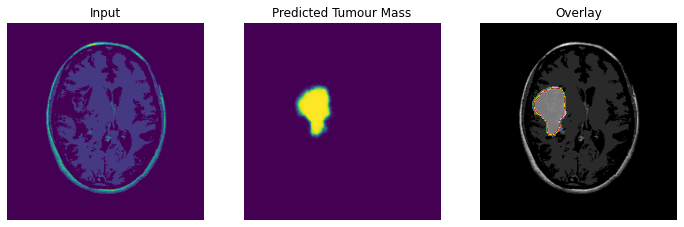

In [ ]:
plt.figure(figsize=(12,10))


# pred
plt.subplot(1,3,1)
plt.title("Input")
plt.imshow(images_train[0,:,:,0])
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Predicted Tumour Mass")
plt.imshow(predictions[0,:,:,0])
plt.axis('off')

plt.subplot(1,3,3)
plt.title('Overlay')
plt.imshow(images_train[0,:,:,0], cmap='gray')
mask = np.ma.masked_where(predictions[0,:,:,0] <= 0.1, predictions[0,:,:,0])
plt.imshow(mask, alpha=0.8, cmap='Set1')
plt.axis('off')

plt.show()

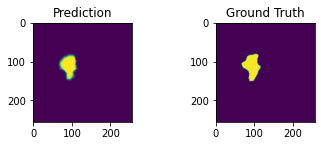

In [ ]:
predictions = combined.predict(images_train[0:1, :])
plt.subplot(221)
plt.title('Prediction')
plt.imshow(predictions[0,:,:,0])
plt.subplot(222)
plt.title('Ground Truth')
plt.imshow(masks_train[0,:,:,0]) 